# Train Transformer
This notebook trains the Transformer and embeds it in a translator class. It is based on the [Neural Machine Translation with a Transformer and Keras](https://www.tensorflow.org/text/tutorials/transformer) tutorial by TensorFlow.

In [41]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [42]:
import tensorflow as tf
from tensorflow.keras import layers
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [43]:
import config

## Dataset and tokenizers
Load dataset and tokenizers, see the tokenization notebook for details. Plot the distribution of tokens per sentence.

In [44]:
train_dataset = tf.data.Dataset.load(config.TRAIN_DATA_PATH)
val_dataset = tf.data.Dataset.load(config.VAL_DATA_PATH)
tokenizers = tf.saved_model.load(config.TOKENIZER_PATH)

In [45]:
lengths = []

for batch in train_dataset.batch(1024):
    eng_tokens = tokenizers.eng.tokenize(batch[:, 0])
    lengths.append(eng_tokens.row_lengths())
    spa_tokens = tokenizers.spa.tokenize(batch[:, 1])
    lengths.append(spa_tokens.row_lengths())

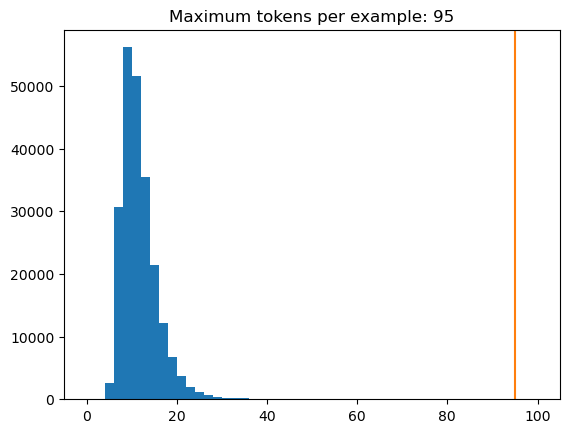

In [46]:
all_lengths = np.concatenate(lengths)

plt.hist(all_lengths, np.linspace(0, 100, 51))
plt.ylim(plt.ylim())
max_length = max(all_lengths)
plt.plot([max_length, max_length], plt.ylim())
plt.title(f"Maximum tokens per example: {max_length}");

## Batches
Split the tokenized dataset into batches for model training.

In [47]:
def prepare_batch(batch):
    eng = batch[:, 0]
    eng = tokenizers.eng.tokenize(eng)  # Output is ragged.
    eng = eng[:, : config.MAX_TOKENS]  # Trim to MAX_TOKENS.
    eng = eng.to_tensor()  # Convert to 0-padded dense Tensor

    spa = batch[:, 1]
    spa = tokenizers.spa.tokenize(spa)
    spa = spa[:, : (config.MAX_TOKENS + 1)]
    spa_inputs = spa[:, :-1].to_tensor()  # Drop the [END] tokens
    spa_labels = spa[:, 1:].to_tensor()  # Drop the [START] tokens

    return (eng, spa_inputs), spa_labels


def make_batches(ds):
    return (
        ds.batch(config.BATCH_SIZE)
        .map(prepare_batch, tf.data.AUTOTUNE)
        .prefetch(buffer_size=tf.data.AUTOTUNE)
    )

In [48]:
val_batches = make_batches(val_dataset)
train_batches = make_batches(train_dataset)

## Transformer
Compile and train the Transformer model.

In [61]:
from model import Transformer

transformer = Transformer(
    num_layers=config.N_LAYERS,
    d_model=config.D_MODEL,
    num_heads=config.N_HEADS,
    dff=config.FFN_DIM,
    input_vocab_size=config.VOCAB_SIZE,
    target_vocab_size=config.VOCAB_SIZE,
    dropout_rate=config.DROPOUT_RATE,
)

In [64]:
transformer.summary()

Model: "transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_1 (Encoder)         multiple                  988160    
                                                                 
 decoder_1 (Decoder)         multiple                  1519360   
                                                                 
 dense_38 (Dense)            multiple                  195000    
                                                                 
Total params: 2702520 (10.31 MB)
Trainable params: 2702520 (10.31 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [65]:
from model import CustomSchedule

learning_rate = CustomSchedule(config.D_MODEL)
optimizer = tf.keras.optimizers.legacy.Adam(
    learning_rate=learning_rate, **config.OPTIMIZER_KWARGS
)

Text(0.5, 0, 'Train Step')

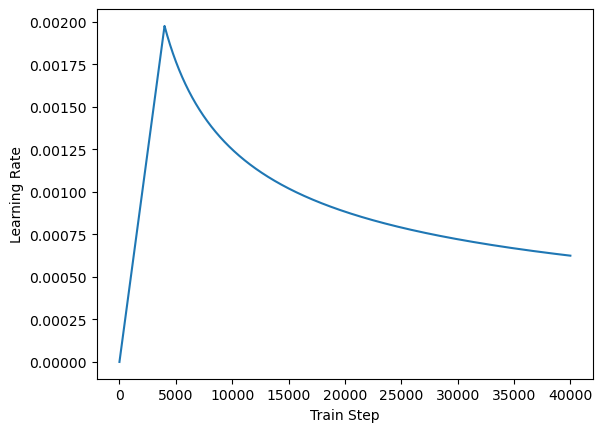

In [66]:
plt.plot(learning_rate(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [67]:
from model import masked_loss, masked_accuracy

transformer.compile(
    loss=masked_loss, optimizer=optimizer, metrics=[masked_accuracy]
)

In [70]:
transformer.fit(
    train_batches, epochs=config.N_EPOCHS, validation_data=val_batches
)

Epoch 1/10
2254/2254 [==============================] - 505s 223ms/step - loss: 4.6335 - masked_accuracy: 0.3104 - val_loss: 2.6951 - val_masked_accuracy: 0.5098
Epoch 2/10
2254/2254 [==============================] - 499s 222ms/step - loss: 2.5677 - masked_accuracy: 0.5120 - val_loss: 1.7944 - val_masked_accuracy: 0.6299
Epoch 3/10
2254/2254 [==============================] - 488s 217ms/step - loss: 2.0031 - masked_accuracy: 0.5926 - val_loss: 1.4413 - val_masked_accuracy: 0.6913
Epoch 4/10
2254/2254 [==============================] - 500s 222ms/step - loss: 1.7351 - masked_accuracy: 0.6356 - val_loss: 1.2849 - val_masked_accuracy: 0.7180
Epoch 5/10
2254/2254 [==============================] - 504s 224ms/step - loss: 1.5910 - masked_accuracy: 0.6599 - val_loss: 1.1904 - val_masked_accuracy: 0.7354
Epoch 6/10
2254/2254 [==============================] - 510s 226ms/step - loss: 1.4936 - masked_accuracy: 0.6768 - val_loss: 1.1229 - val_masked_accuracy: 0.7488
Epoch 7/10
2254/2254 [======

## Translator
Use the Transformer model and tokenizers in a translator.

In [91]:
from model import Translator, ExportTranslator

translator = Translator(tokenizers, transformer, max_length=config.MAX_TOKENS)

In [92]:
def print_translation(sentence, tokens, ground_truth):
    print(f'{"Input:":15s}: {sentence}')
    print(f'{"Prediction":15s}: {tokens.numpy().decode("utf-8")}')
    print(f'{"Ground truth":15s}: {ground_truth}')

In [93]:
sentence = "this is a problem we have to solve ."
ground_truth = "este es un problema que tenemos que resolver ."

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence)
)
print_translation(sentence, translated_text, ground_truth)

Input:         : this is a problem we have to solve .
Prediction     : este es un problema que tenemos que solucionar .
Ground truth   : este es un problema que tenemos que resolver .


In [94]:
translator = ExportTranslator(translator)

In [95]:
translator("i like trains .").numpy()

b'me gustan los trenes .'

In [96]:
tf.saved_model.save(translator, export_dir=config.TRANSLATOR_PATH)

INFO:tensorflow:Assets written to: translator/assets


INFO:tensorflow:Assets written to: translator/assets
